In [1]:
pip install torch torchvision torchaudio

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/d6/a8/43e5033f9b2f727c158456e0720f870030ad3685c46f41ca3ca901b54922/torch-2.1.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/13/24/23cdf7e7dc33e5c01588c315f8424d31afa9edb05a80168f3d44f7178ff7/torchvision-0.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/3e/c4/bfaa620bba2e53e7707295bcc07b65871a52efe84510340ad79ce6a69be0/torchaudio-2.1.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/192.3 MB 1.9 MB/s eta 0:01:41
   ---------------------------------------- 0.1/192.3 MB 1.1 MB/s eta 0:03:04
   ---------------------------------------- 0.2/192.3 MB 1.1 MB/s eta 0:02:57
   ---------------------------------------- 0.2/192.3 MB 1.0

In [3]:
!pip install keras_tuner -q

# Build a Neural network with Hyper-parameter fine tuning model

In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from keras_tuner import RandomSearch

In [5]:
Trails=2 
epochs=2

In [6]:
(xtrain,ytrain),(xval,yval)=fashion_mnist.load_data()
xtrain=np.expand_dims(xtrain.astype('float32')/255.,-1)
xval=np.expand_dims(xval.astype('float32')/255.,-1)
ytrain=to_categorical(ytrain,10)
yval=to_categorical(yval,10)

4422102/4422102 [==============================] - 3s 1us/step


In [7]:
def build_model(hp):
    """
    Function to build a TF model based on hyperparameter values
    
    Args:
    hp (hyperparameter): values
    
    Returns:
    Model: compiled model
    """
    num_layers = hp.Int('num_layers', 2, 8, default=6)
    lr = hp.Choice('learning_rate', [0.0001, 0.05])
    inputs = layers.Input(shape=(28, 28, 1))
    x = inputs
    for idx in range(num_layers):
        idx_str = str(idx)
        filters = hp.Int('filters_' + idx_str, 32, 256, step=32, default=64)
        x = layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)

        if x.shape[1] >= 8:
            pool_type = hp.Choice('pool_' + idx_str, values=['max', 'avg'])
            if pool_type == 'max':
                x = layers.MaxPooling2D(2)(x)
            elif pool_type == 'avg':
                x = layers.AveragePooling2D(2)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    # Build model
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
tuner=RandomSearch(build_model,objective='val_accuracy',max_trials=Trails,
 project_name='Fashion_MNIST_results')


In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
num_layers (Int)
{'default': 6, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.05], 'ordered': True}
filters_0 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
pool_0 (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'avg'], 'ordered': False}
filters_1 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
pool_1 (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'avg'], 'ordered': False}
filters_2 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
filters_3 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
filters_4 (Int)
{'default': 64, 'conditions': [], 'min_value

In [10]:
tuner.search(xtrain,ytrain,batch_size=128,epochs=2,validation_data=(xval,yval))

Trial 2 Complete [00h 02m 41s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.10000000149011612
Total elapsed time: 00h 03m 54s


In [11]:
tuner.results_summary()

Results summary
Results in .\Fashion_MNIST_results
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
num_layers: 6
learning_rate: 0.05
filters_0: 32
pool_0: avg
filters_1: 192
pool_1: max
filters_2: 96
filters_3: 64
filters_4: 64
filters_5: 32
Score: 0.10000000149011612

Trial 1 summary
Hyperparameters:
num_layers: 8
learning_rate: 0.05
filters_0: 32
pool_0: avg
filters_1: 64
pool_1: max
filters_2: 224
filters_3: 224
filters_4: 96
filters_5: 128
filters_6: 64
filters_7: 64
Score: 0.10000000149011612


In [12]:
best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 192)       55488     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 192)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 96)          16598

# Build an image classifier model with Pytorch

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4
trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                     download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(root='./data', split='test',
                                    download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))


100%|███████████████████████████████████████████████████████████████| 182040794/182040794 [02:02<00:00, 1490418.44it/s]


100%|█████████████████████████████████████████████████████████████████| 64275384/64275384 [00:31<00:00, 2014724.33it/s]


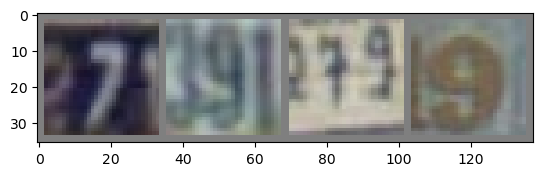

7     9     7     9    


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
for epoch in range(2):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
 
        inputs, labels = data
 
        optimizer.zero_grad()
    
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
        if i % 2000 == 1999: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.248
[1,  4000] loss: 2.236
[1,  6000] loss: 2.034
[1,  8000] loss: 1.111
[1, 10000] loss: 0.765
[1, 12000] loss: 0.660
[1, 14000] loss: 0.613
[1, 16000] loss: 0.556
[1, 18000] loss: 0.547
[2,  2000] loss: 0.493
[2,  4000] loss: 0.471
[2,  6000] loss: 0.463
[2,  8000] loss: 0.428
[2, 10000] loss: 0.461
[2, 12000] loss: 0.466
[2, 14000] loss: 0.426
[2, 16000] loss: 0.440
[2, 18000] loss: 0.419
Finished Training


In [19]:
PATH = './svhn_net.pth'
torch.save(net.state_dict(), PATH)

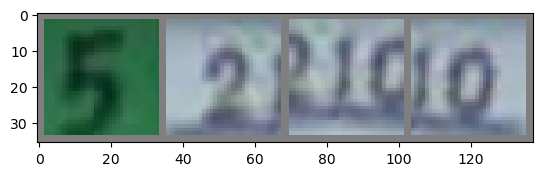

GroundTruth:  5     2     1     0    


In [20]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

In [21]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
outputs = net(images)

In [23]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
 for j in range(3)))

Predicted:  5     2     1    


In [24]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')


Accuracy of the network on the 10000 test images: 85.04532882606023%


In [25]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f}%')


Accuracy for class: 0     is 87.0%
Accuracy for class: 1     is 89.9%
Accuracy for class: 2     is 84.3%
Accuracy for class: 3     is 83.7%
Accuracy for class: 4     is 91.1%
Accuracy for class: 5     is 77.9%
Accuracy for class: 6     is 83.9%
Accuracy for class: 7     is 92.7%
Accuracy for class: 8     is 67.5%
Accuracy for class: 9     is 83.1%
